## Random Forest

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 集成基本思想：

训练时用多种分类器一起完成同一份任务

![title](./img/1.png)

测试时对待测试样本分别通过不同的分类器，汇总最后的结果

![title](./img/2.png)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

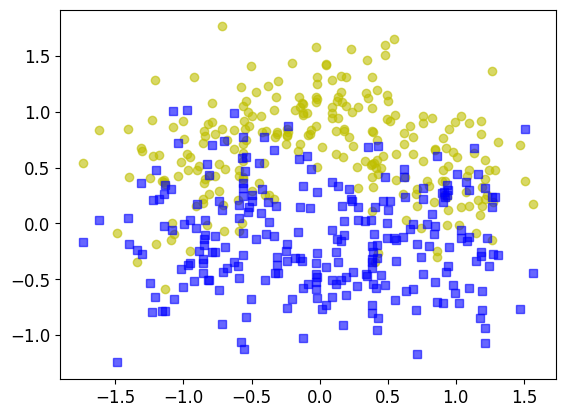

In [3]:
plt.plot(X[:,0][y==0],X[:,1][y==0],'yo',alpha = 0.6)
plt.plot(X[:,0][y==0],X[:,1][y==1],'bs',alpha = 0.6)

### 投票策略：软投票与硬投票
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权平均

#### 硬投票实验

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 1
log_clf = LogisticRegression(random_state=42)
# 2
rnd_clf = RandomForestClassifier(random_state=42)
# 3
svm_clf = SVC(random_state=42)
# 投票分类器 1|2|3 硬投票
voting_clf = VotingClassifier(estimators =[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='hard')

In [5]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

LogisticRegression : 0.864
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        68
           1       0.81      0.91      0.86        57

    accuracy                           0.86       125
   macro avg       0.87      0.87      0.86       125
weighted avg       0.87      0.86      0.86       125

RandomForestClassifier : 0.896
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        68
           1       0.84      0.95      0.89        57

    accuracy                           0.90       125
   macro avg       0.90      0.90      0.90       125
weighted avg       0.90      0.90      0.90       125

SVC : 0.896
              precision    recall  f1-score   support

           0       0.98      0.83      0.90        72
           1       0.81      0.98      0.89        53

    accuracy                           0.90       125
   macro avg       0.90      0.91      0.90       125
weig

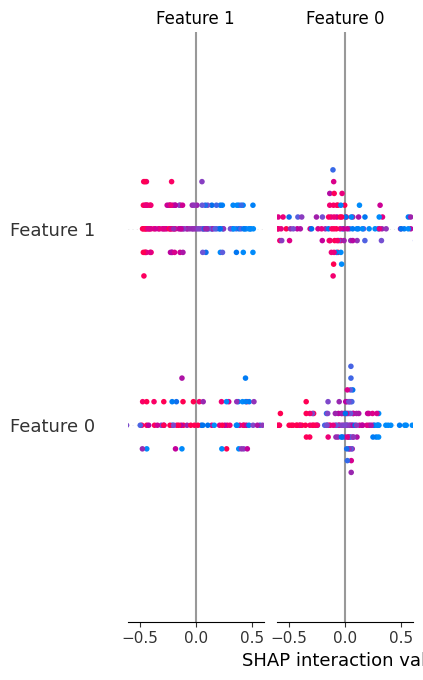

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# load JS visualization code to notebook
shap.initjs()
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print (clf.__class__.__name__,":",accuracy_score(y_test,y_pred))
    print(classification_report(y_pred, y_test))
explainer = shap.TreeExplainer(rnd_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### 软投票实验

In [15]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)

svm_clf = SVC(probability = True,random_state=42)

voting_clf = VotingClassifier(estimators =[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],voting='soft')

In [16]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [17]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print (clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


软投票：要求必须各个分别器都能得出概率值

### 1 Bagging策略
- 首先对训练数据集进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需得到所有模型结果再进行集成

![title](./img/3.png)

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            bootstrap=True,
                            n_jobs=-1,
                            random_state=42
                            )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


In [19]:
print("Decision Tree With Bagging:",accuracy_score(y_test,y_pred))

Decision Tree With Bagging: 0.904


In [20]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train,y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree:",accuracy_score(y_test,y_pred_tree))

Decision Tree: 0.856


#### 决策边界
- 集成与传统方法对比

In [ ]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    colors = ["green", "red", "gold"]
    colors2 = ["orange", "blue", "purple"]

    custom_cmap = ListedColormap(colors)
    plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.3)
    if contour:
        custom_cmap2 = ListedColormap(colors2)
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', alpha=0.6)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 1], 'bs', alpha=0.6)
    plt.axis(axes)
    plt.xlabel('x1')
    plt.xlabel('x2')


In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plot_decision_boundary(tree_clf,X,y)
plt.title('Decision Tree')
plt.subplot(122)
plot_decision_boundary(bag_clf,X,y)
plt.title('Decision Tree With Bagging')

Colormap颜色：https://blog.csdn.net/zhaogeng111/article/details/78419015

#### OOB策略
- Out Of Bag 不在训练集中的数据 作为验证集

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                  n_estimators = 500,
                  max_samples = 100,
                  bootstrap = True,
                  n_jobs = -1,
                  random_state = 42,
# 增加oob参数   
                  oob_score = True
)
bag_clf.fit(X_train,y_train)
# oob值
bag_clf.oob_score_

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

In [ ]:
# 每个样本属于及不属于这个类别的概率
bag_clf.oob_decision_function_

#### 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

#### 特征重要性
sklearn中是看每个特征的平均深度

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(iris['data'],iris['target'])
# feature_importances_ 特征重要性
for name,score in zip(iris['feature_names'],rf_clf.feature_importances_):
    print (name,score)

Mnist中哪些特征比较重要呢？

In [ ]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')

from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(mnist['data'],mnist['target'])

In [ ]:
rf_clf.feature_importances_.shape

In [ ]:
# 热度图
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis('off')

In [ ]:
plot_digit(rf_clf.feature_importances_)
# colorbar展示 feature_importances_ 特征重要性 最小-最大
char = plt.colorbar(ticks=[rf_clf.feature_importances_.min(),rf_clf.feature_importances_.max()])
char.ax.set_yticklabels(['Not important','Very important'])

### 2 Boosting-提升策略

#### AdaBoost
跟上学时的考试一样，这次做错的题，是不是得额外注意，下次的时候就和别错了！

![title](./img/4.png)

以**SVM分类器**为例来演示AdaBoost的基本策略

In [ ]:
from sklearn.svm import SVC
# 样本个数
m = len(X_train)

plt.figure(figsize=(14,5))
# 子图对比
for subplot,learning_rate in ((121,1),(122,0.5)):
    # 初始权重为1
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        # 实例化Support Vector Classification, C:核函数
        svm_clf = SVC(kernel='rbf',C=0.05,random_state=42)
        svm_clf.fit(X_train,y_train,sample_weight = sample_weights)
        y_pred = svm_clf.predict(X_train)
        # 权重调整
        sample_weights[y_pred != y_train] *= (1+learning_rate)
        plot_decision_boundary(svm_clf,X,y,alpha=0.2)
        plt.title('learning_rate = {}'.format(learning_rate))
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=24, color="w")
        plt.text(-0.6, -0.10, "2", fontsize=24, color="w")
        plt.text(-0.5,  0.10, "3", fontsize=24, color="w")
        plt.text(-0.4,  0.55, "4", fontsize=24, color="w")
        plt.text(-0.3,  0.90, "5", fontsize=24, color="w")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                   n_estimators = 200,
                   learning_rate = 0.5,
                   random_state = 42
)

In [ ]:
ada_clf.fit(X_train,y_train)
plot_decision_boundary(ada_clf,X,y)

#### Gradient Boosting
> XGBoost stands for Extreme Gradient Boosting
> 
> - 梯度提升决策树GBDT/梯度提升回归树GBRT
> - XGBoost
> - lightgbm

In [ ]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3*X[:,0]**2 + 0.05*np.random.randn(100)

In [ ]:
y.shape

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X,y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
# y 根据第一次结果进行调整
tree_reg2.fit(X,y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X,y3)

In [ ]:
X_new = np.array([[0.8]])
# 串联3棵树
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))
y_pred

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [ ]:
# GBRT
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbrt = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 1.0,
                          random_state = 41
)
gbrt.fit(X,y)

In [ ]:
gbrt_slow_1 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 3,
                          learning_rate = 0.1,
                          random_state = 41
)
gbrt_slow_1.fit(X,y)

In [ ]:
gbrt_slow_2 = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = 200,
                          learning_rate = 0.1,
                          random_state = 41
)
gbrt_slow_2.fit(X,y)

In [ ]:
# 第一组对比实验 学习率
plt.figure(figsize = (11,4))
plt.subplot(121)
plot_predictions([gbrt],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt.learning_rate,gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))

In [ ]:
# 第二组对比实验 迭代次数
plt.figure(figsize = (11,4))
plt.subplot(121)
# gbrt_slow_2
plot_predictions([gbrt_slow_2],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_2.learning_rate,gbrt_slow_2.n_estimators))

plt.subplot(122)
# gbrt_slow_1
plot_predictions([gbrt_slow_1],X,y,axes=[-0.5,0.5,-0.1,0.8],label = 'Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,gbrt_slow_1.n_estimators))

#### 提前停止策略
![](img/early_stopping.jpeg)

In [ ]:
from sklearn.metrics import mean_squared_error
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=49)
steps = 120
gbrt = GradientBoostingRegressor(max_depth = 2,
                                 n_estimators=steps,
                          random_state = 42
)
gbrt.fit(X_train,y_train)
# staged_predict 每阶段预测
# mean_squared_error 均方误差
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
# 最好的迭代次数
bst_n_estimators = np.argmin(errors)
print(bst_n_estimators)
gbrt_best = GradientBoostingRegressor(max_depth = 2,
                          n_estimators = bst_n_estimators,
                          random_state = 42
)
gbrt_best.fit(X_train,y_train)

In [ ]:
min_error = np.min(errors)
min_error

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(errors,'k.-')
plt.plot([bst_n_estimators,bst_n_estimators],[0,min_error],'m--')
plt.plot([0,120],[min_error,min_error],'b--')
# 坐标轴调整
plt.axis([0,120,0,0.007])
plt.title('Val Error')

plt.subplot(122)
plot_predictions([gbrt_best],X,y,axes=[-0.5,0.5,-0.1,0.8])
plt.title('Best Model(%d trees)'%bst_n_estimators)


In [ ]:
# warm_start 热启动 继续前次训练
gbrt = GradientBoostingRegressor(max_depth = 2,
                             random_state = 42,
                                 warm_start =True
)
error_going_up = 0
min_val_error = float('inf')

for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up == 5:
            break

In [ ]:
print (gbrt.n_estimators)

### 3 Stacking（堆叠集成）

![title](./img/5.png)

![title](./img/6.png)

In [ ]:
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# mnist = fetch_mldata('MNIST original')
mnist = fetch_openml("mnist_784")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
# 1
random_forest_clf = RandomForestClassifier(random_state=42)
# 2
extra_trees_clf = ExtraTreesClassifier(random_state=42)
# 3
svm_clf = LinearSVC(random_state=42)
# 4
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

In [ ]:
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
print("第一阶段预测结果:",X_val_predictions)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
# 第一阶段预测结果作为第二阶段特征输入
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_